In [1]:
!pip install yfinance
!apt-get install git



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [2]:
!git --version


git version 2.34.1


In [ ]:
# Portfolio Analysis Tool with main()
# This tool is designed to analyze investment portfolios by fetching historical data,
# calculating key metrics, and providing visualizations. Future updates will add more features.

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [ ]:
def fetch_data(assets):
    """Fetch historical data for given assets over the last 5 years."""
    # Calculate the start and end dates (5 years from today)
    end_date = datetime.today()
    start_date = end_date - timedelta(days=5*365)

    # Initialize an empty DataFrame to store adjusted close prices
    all_data = pd.DataFrame()

    for asset in assets:
        try:
            # Download data
            data = yf.download(asset, start=start_date, end=end_date)['Adj Close']
            # Check if data is available for at least 4.5 years (~90% of 5 years)
            if len(data) >= 0.9 * (5 * 252):  # 252 trading days per year
                all_data[asset] = data
            else:
                print(f"Insufficient data for {asset}. Excluding from portfolio.")
        except Exception as e:
            print(f"Error fetching data for {asset}: {e}. Excluding from portfolio.")

    return all_data.dropna(axis=1)

In [ ]:
import numpy as np

def calculate_portfolio_metrics(data, weights, risk_free_rate=0.03):
    """Calculate portfolio metrics: CAGR, annualized risk, and Sharpe ratio."""
    # Calculate periodic returns
    returns = data.pct_change().dropna()

    # Calculate CAGR for the portfolio
    initial_values = data.iloc[0, :]
    final_values = data.iloc[-1, :]
    years = len(data) / 12  # Assuming monthly data

    cagr = {
        asset: (final_values[asset] / initial_values[asset]) ** (1 / years) - 1
        for asset in data.columns
    }

    # Calculate annualized return for risk (volatility)
    annual_returns = returns.mean() * 12
    annualized_risk = returns.std() * np.sqrt(12)

    # Normalize weights
    normalized_weights = [w / sum(weights) for w in weights]

    # Portfolio metrics
    portfolio_return = np.dot(normalized_weights, list(cagr.values()))  # Use CAGR for return
    cov_matrix = returns.cov() * 12
    portfolio_variance = np.dot(normalized_weights, np.dot(cov_matrix, normalized_weights))
    portfolio_std_dev = np.sqrt(portfolio_variance)

    # Sharpe Ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std_dev

    # Return portfolio metrics
    return {
        "Expected Return (CAGR)": portfolio_return,
        "Risk (Annualized Std Dev)": portfolio_std_dev,
        "Sharpe Ratio": sharpe_ratio
    }


In [ ]:
def plot_allocation(weights, assets):
    """Visualize portfolio allocation."""
    plt.figure(figsize=(6, 6))
    plt.pie(weights, labels=assets, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired(range(len(assets))))
    plt.title("Portfolio Allocation")
    plt.show()

In [ ]:
# input_handling.py
# Functions for handling portfolio input

import pandas as pd
import yfinance as yf

def get_portfolio_input():
    """
    Automatically process portfolio input from a CSV file.
    Returns a DataFrame with Ticker, Name, and Weight columns.
    Also downloads monthly historical data for the tickers and saves it to a CSV file.
    """
    file_path = input("Enter the path to your CSV file: ").strip()
    try:
        # Read CSV file
        data = pd.read_csv(file_path, header=0)
        print("CSV File Preview:")
        print(data.head())

        # Dynamically identify columns for Ticker and Weight
        ticker_col = None
        weight_col = None

        for col in data.columns:
            if "ticker" in col.lower():
                ticker_col = col
            elif "weight" in col.lower():
                weight_col = col

        if not ticker_col or not weight_col:
            raise KeyError("The CSV file must contain columns for Ticker and Weight.")

        # Extract tickers and weights
        tickers = data[ticker_col].tolist()
        weights = list(map(float, data[weight_col]))

        # Get names if available, otherwise fetch from API
        if 'Name' in data.columns:
            names = data['Name'].tolist()
        else:
            print("Fetching asset names from API...")
            names = []
            for ticker in tickers:
                try:
                    asset = yf.Ticker(ticker)
                    names.append(asset.info.get('shortName', 'Unknown'))
                except Exception:
                    names.append('Unknown')

        # Validate weights
        if not all(w > 0 for w in weights):
            raise ValueError("All weights must be positive numbers.")

        # Normalize weights if they do not sum to 1
        total_weight = sum(weights)
        if total_weight != 1.0:
            weights = [w / total_weight for w in weights]
            print("Weights were normalized to sum to 1.")

        # Download monthly data for each ticker and save to CSV
        print("Downloading monthly historical data for tickers...")
        historical_data = pd.DataFrame()

        for ticker in tickers:
            try:
                ticker_data = yf.download(ticker, interval='1mo', period='5y')
                ticker_data['Ticker'] = ticker
                historical_data = pd.concat([historical_data, ticker_data])
            except Exception as e:
                print(f"Failed to download data for {ticker}: {e}")

        # Save the historical data to a CSV file
        historical_data.to_csv("historical_data.csv")
        print("Historical data saved to historical_data.csv")

        # Create DataFrame to return
        portfolio_df = pd.DataFrame({
            'Ticker': tickers,
            'Name': names,
            'Weight': weights
        })

    except FileNotFoundError:
        print("Error: The specified file was not found.")
        return get_portfolio_input()
    except KeyError as e:
        print(f"Error: {e}")
        return get_portfolio_input()
    except ValueError as e:
        print(f"Error: {e}")
        return get_portfolio_input()

    return portfolio_df


Enter the path to your CSV file: /content/sample_portfolio_data (1).csv
CSV File Preview:
  Ticker  Weight (%)
0   AAPL        20.0
1   MSFT        15.0
2   TSLA        10.0
3   AMZN        20.0
4   NVDA        10.0
Fetching asset names from API...


[*********************100%***********************]  1 of 1 completed

Weights were normalized to sum to 1.



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Historical data saved to historical_data.csv


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Insufficient data for BAM. Excluding from portfolio.

Portfolio Metrics:
Expected Return (CAGR): 0.0135
Risk (Annualized Std Dev): 0.0619
Sharpe Ratio: -0.2658


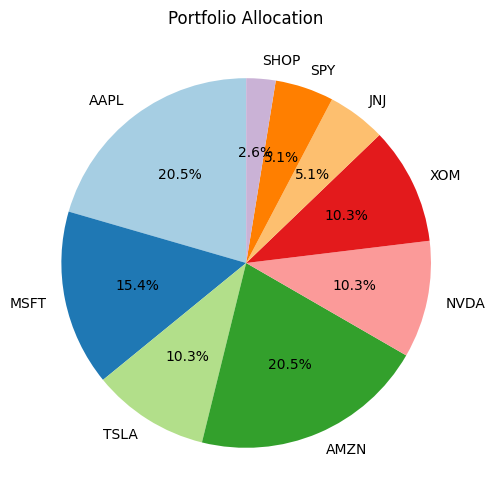

In [ ]:
def main():
    # Step 1: Get portfolio input
    portfolio_df = get_portfolio_input()

    # Extract assets and weights from the returned DataFrame
    assets = portfolio_df['Ticker'].tolist()
    weights = portfolio_df['Weight'].tolist()

    # Step 2: Fetch historical data
    all_data = fetch_data(assets)

    # Step 3: Recalculate weights for remaining assets
    remaining_assets = all_data.columns.tolist()
    remaining_weights = [weights[assets.index(asset)] for asset in remaining_assets]
    total_weight = sum(remaining_weights)
    normalized_weights = [w / total_weight for w in remaining_weights]

    # Step 4: Calculate portfolio metrics
    metrics = calculate_portfolio_metrics(all_data, normalized_weights)

    # Display portfolio metrics
    print("\nPortfolio Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    # Step 5: Visualize portfolio allocation
    plot_allocation(normalized_weights, remaining_assets)

# Entry point for the script
if __name__ == "__main__":
    main()


In [10]:
%cd portfolio-analysis-tool/


/content/portfolio-analysis-tool


In [11]:
!git add portfolio_analysis.ipynb


fatal: pathspec 'portfolio_analysis.ipynb' did not match any files


In [18]:
!ls
